In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time

%matplotlib inline

import difi
from difi import __version__
print("difi version: {}".format(__version__))

difi version: 1.1.dev41+gfe1620d


In [2]:
DATA_DIR = "../data"

In [3]:
observations = pd.read_csv(
    os.path.join(DATA_DIR, "observations.txt"), 
    index_col=False, 
    sep=" "
)
len(observations)

13775715

In [4]:
# Remove SR because we don't know what they are
observations = observations[~observations["truth"].str.contains("^SR", regex=True)]
len(observations)

13773755

In [5]:
column_mapping = {
    "obs_id" : "obs_id", # Observation ID
    "truth" : "truth", # Object to which each observation belongs to
    "time" : "mjd_utc",
    "night" : "night",
    "linkage_id" : "trkSub"
}

In [6]:
# Read known objects 
from thor.utils import unpackMPCDesignation

# Taken from old version of THOR
def readMPCORBFile(file,
                   con=None):
    """
    Read MPCORB.DAT file into a pandas DataFrame.
    For more details about the MPCORB file:
    https://www.minorplanetcenter.net/iau/MPCORB.html
    
    Parameters
    ----------
    file : str
        Path to MPCORB.dat
    con : `~sqlite3.Connection`, optional
        If a database connection is passed, will save
        DataFrame into database as mpcOrbitCat table.
        
    Returns
    -------
    `~pandas.DataFrame` or None
        If database connection is not passed, will
        return DataFrame of the MPC Orbit Catalog file.
    """
    columns = ["designation",
               "H",
               "G", 
               "epoch_pf_TT",
               "meanAnom_deg",
               "argPeri_deg",
               "ascNode_deg",
               "i_deg",
               "e", 
               "n_deg_p_day",
               "a_au",
               "U",
               "ref",
               "numObs",
               "numOppos",
               "obsArc",
               "rmsResid_arcsec",
               "coarsePerturbers",
               "precisePerturbers",
               "compName", 
               "flags",
               "readableDesignation",
               "lastObsInOrbitSolution"]

    # See: https://www.minorplanetcenter.net/iau/info/MPOrbitFormat.html
    column_spec = [(0, 7),
                   (8, 13),
                   (14, 19),
                   (20, 25),
                   (26, 35),
                   (37, 46),
                   (48, 57),
                   (59, 68),
                   (70, 79),
                   (80, 91),
                   (92, 103),
                   (105, 106),
                   (107, 116),
                   (117, 122),
                   (123, 126),
                   (127, 136),
                   (137, 141),
                   (142, 145),
                   (146, 149),
                   (150, 160),
                   (161, 165),
                   (166, 194),
                   (194, 202)]

    dtypes = {"H" : np.float64,
              "G" : np.float64,
              "epoch_pf_TT" : str,
              "meanAnom_deg" : np.float64,
              "argPeri_deg" : np.float64,
              "ascNode_deg" : np.float64,
              "i_deg" : np.float64,
              "e" : np.float64,
              "n_deg_p_day" : np.float64,
              "a_au" : np.float64,
              "U" : str,
              "ref" : str,
              "numObs" : np.int64,
              "numOppos" : np.int64,
              "obsArc" : str,
              "rmsResid_arcsec" : np.float64,
              "coarsePerturbers" : str,
              "precisePerturbers" : str,
              "compName" : str,
              "lastObsInOrbitSolution" : np.int64}
    
    converters = {"designation": lambda x: str(x),
                  "readableDesignation" : lambda x: str(x),
                  "flags" : lambda x: str(x)}
    
    mpcorb = pd.read_fwf(file,
                         skiprows=43,
                         colspecs=column_spec,
                         header=None,
                         index_col=False, 
                         names=columns,
                         dtypes=dtypes,
                         converters=converters)
    mpcorb = mpcorb[~mpcorb["designation"].isna()]
    return mpcorb

mpcorb = readMPCORBFile("../data/mpc/MPCORB_2020_9_14.DAT")
mpcorb["designation_unpacked"] = mpcorb["designation"].apply(unpackMPCDesignation)

In [7]:
classes = {
    "NEOs" : observations[observations[column_mapping["truth"]].str.contains("^S0", regex=True)][column_mapping["truth"]].unique(),
    "MBAs" : observations[observations[column_mapping["truth"]].str.contains("^S1", regex=True)][column_mapping["truth"]].unique(),
    "Trojans" : observations[observations[column_mapping["truth"]].str.contains("^St5", regex=True)][column_mapping["truth"]].unique(),
    "SDOs" : observations[observations[column_mapping["truth"]].str.contains("^SS", regex=True)][column_mapping["truth"]].unique(),
    "TNOs" : observations[observations[column_mapping["truth"]].str.contains("^ST", regex=True)][column_mapping["truth"]].unique(),
    "MPC" : mpcorb["designation_unpacked"].unique()
}

obj_ids = []
for c, o in classes.items():
    obj_ids.append(o)

obj_ids = np.concatenate(obj_ids)
# Make sure all objects are accounted for
assert len(observations[~observations[column_mapping["truth"]].isin(obj_ids)]) == 0

In [8]:
for c, o in classes.items():
    observations.loc[observations[column_mapping["truth"]].isin(o), "class"] = c
    
assert len(observations[observations["class"].isna()]) == 0

In [9]:
# Make sure that every observations has a "class" (see last column of dataframe)
observations.head()

,obs_id,obj_id,mjd_utc,ra,dec,rmsRA,rmsDec,band,mag,rmsMag,stn,mode,astCat,night,truth,class
0,obs00000000,NaN,59853.985644,293.446596,3.515798,0.084315,0.084474,z,21.247000,0.100685,I11,CCD,Gaia2,59854,S00000pWa,NEOs
1,obs00000001,NaN,59853.985644,295.982446,3.173437,0.014006,0.014027,z,18.708965,0.012302,I11,CCD,Gaia2,59854,159342,MPC
2,obs00000002,NaN,59853.985644,295.727681,4.253175,0.115598,0.115917,z,21.601910,0.136325,I11,CCD,Gaia2,59854,2014 WS484,MPC
3,obs00000003,NaN,59853.985644,295.458455,5.114469,0.011877,0.011924,z,18.138789,0.008138,I11,CCD,Gaia2,59854,86666,MPC
4,obs00000004,NaN,59853.985644,294.949611,6.066191,0.559205,0.562354,z,23.336774,0.544599,I11,CCD,Gaia2,59854,2007 VD177,MPC


In [10]:
def simulateSSP(observations, 
                classes=None,
                known_objects=classes["MPC"],
                linking_window_size=15, 
                attribution=True, 
                precovery=True,
                column_mappling=column_mapping):
    """
    Simulate the discovery perforance of Rubin Obs / LSST's 
    Solar System Pipelines (SSP).
    
    
    """
    # Track "known" objects
    if known_objects is None:
        known_obj_ids = np.array([])
    else:
        known_obj_ids = known_objects
    
    # Track the observation IDs linked
    obs_ids_linked = np.array([])
    
    # If attribution is assumed, track attributed observations
    attributed_obs_ids = np.array([])

    # If precovery is assumed, track attributed observations
    precovery_obs_ids = np.array([])
    
    linkage_id_start = 0
    linkage_members_list = []
    all_linkages_list = []
    all_truths_list = []
    observations_ap_list = []
    summary_list = []

    for i, night_end in enumerate(sorted(observations[column_mapping["night"]].unique())):
        
         # Only consider observations inside the linking window
        linking_window_mask = (
            (observations[column_mapping["night"]] >= (night_end - linking_window_size))
            & (observations[column_mapping["night"]] <= night_end)
        )
        
        print("Night ({}/{}): {}".format(
            i + 1,
            observations[column_mapping["night"]].nunique(),
            night_end
            )
        )
        
        # Run precovery of known object observations for all nights previous to night_end
        if precovery:
            precovery_mask = (
                (observations[column_mapping["night"]] < night_end)
                & (observations[column_mapping["truth"]].isin(known_obj_ids))
                & (~observations[column_mapping["obs_id"]].isin(precovery_obs_ids))
                & (~observations[column_mapping["obs_id"]].isin(attributed_obs_ids))
                & (~observations[column_mapping["obs_id"]].isin(obs_ids_linked))
            )
            precovery_obs_ids_iter = observations[precovery_mask][column_mapping["obs_id"]].values
        else:
            precovery_obs_ids_iter = np.array([])
        precovery_obs_ids =  np.concatenate([precovery_obs_ids, precovery_obs_ids_iter])
        
        # Run attribution of known object observations for night_end
        if attribution:
            attribution_mask = (
                (observations[column_mapping["night"]] == night_end)
                & (observations[column_mapping["truth"]].isin(known_obj_ids))
               
            )
            attributed_obs_ids_iter = observations[attribution_mask][column_mapping["obs_id"]].values

        else: 
            attributed_obs_ids_iter = np.array([])
        attributed_obs_ids =  np.concatenate([attributed_obs_ids, attributed_obs_ids_iter])
        
        # Remove already linked observations and observations attributed to
        # previous discoveries
        observations_mask = (
            linking_window_mask
            & (~observations[column_mapping["obs_id"]].isin(obs_ids_linked))
            & (~observations[column_mapping["obs_id"]].isin(precovery_obs_ids))
            & (~observations[column_mapping["obs_id"]].isin(attributed_obs_ids))
        )

        print("Observations between night {} and {}: {}".format(
            observations[observations_mask][column_mapping["night"]].min(),
            night_end,
            len(observations[observations_mask])
            ) 
        )

        # Find what should be findable up to the end night
        all_truths, findable_observations, summary = difi.analyzeObservations(
            observations[observations_mask],
            classes=classes,
            metric="nightly_linkages",
            linkage_min_obs=2,
            min_linkage_nights=3,
            max_obs_separation=1.5/24,
            column_mapping=column_mapping
        )
        all_truths["submission_night"] = [night_end for i in range(len(all_truths))]
        summary["submission_night"] = [night_end for i in range(len(summary))]

        if len(findable_observations) > 0:

            # Convert findable observations into a linkage_members data frame
            linkage_members = findable_observations["obs_ids"].apply(pd.Series).stack().to_frame(name="obs_id")
            linkage_members.reset_index(
                level=1, 
                drop=True,
                inplace=True
            )

            # Rename new index to trkSub
            linkage_members.index.name = "trkSub"
            linkage_members.reset_index(
                inplace=True,
                drop=False
            )
            # Convert trkSub from an integer to a unique string identifier
            linkage_members["trkSub"] = linkage_members["trkSub"].apply(
                lambda x: "t{:07d}".format(x + linkage_id_start)
            )
            linkage_members_list.append(linkage_members)

            # Create all_linkages data frame
            trkSubs = linkage_members["trkSub"].unique()
            all_linkages = pd.DataFrame({
                "trkSub" : trkSubs,
                "submission_night" : [night_end for i in range(len(trkSubs))]
            })

            # Increase linkage ID start value
            linkage_id_start += len(trkSubs)

            # Add linked observations to running list
            obs_ids_linked_iter = linkage_members[column_mapping["obs_id"]].values
            obj_ids_linked_iter = findable_observations[column_mapping["truth"]].values

        else:
            obs_ids_linked_iter = np.array([])
            obj_ids_linked_iter = np.array([])
            linkage_members = pd.DataFrame(
                columns=[column_mapping["linkage_id"], column_mapping["obs_id"]]
            )
            all_linkages = pd.DataFrame(
                columns=[column_mapping["linkage_id"], "submission_night"]
            )
            
        obs_ids_linked = np.concatenate([obs_ids_linked, obs_ids_linked_iter])
        known_obj_ids = np.concatenate([known_obj_ids, obj_ids_linked_iter])
            
        observations_a = pd.DataFrame({
            column_mapping["obs_id"] : attributed_obs_ids_iter,
            "attributed" : [1 for i in range(len(attributed_obs_ids_iter))],
        })
        observations_p = pd.DataFrame({
            column_mapping["obs_id"] : precovery_obs_ids_iter,
            "precovered" : [1 for i in range(len(precovery_obs_ids_iter))],
        })
        
        observations_ap = pd.concat([observations_a, observations_p])
        observations_ap["submission_night"] = [night_end for i in range(len(observations_ap))]
        observations_ap_list.append(observations_ap)
            
        all_linkages_analyzed, all_truths, summary = difi.analyzeLinkages(
            observations,
            linkage_members,
            all_truths=all_truths,
            min_obs=6,
            contamination_percentage=0,
            classes=classes,
            column_mapping=column_mapping,
        )

        all_linkages = all_linkages.merge(
            all_linkages_analyzed,
            on=column_mapping["linkage_id"],
        )
        all_linkages_list.append(all_linkages)

        all_truths["submission_night"] = [night_end for i in range(len(all_truths))]
        summary["submission_night"] = [night_end for i in range(len(summary))]
            
        summary_list.append(summary)
        all_truths_list.append(all_truths)
        
        print("Known objects: {}".format(len(known_obj_ids)))
        print("Observations linked: {}".format(len(obs_ids_linked_iter)))
        print("Observations precovered: {}".format(len(precovery_obs_ids_iter)))
        print("Observations attributed: {}".format(len(attributed_obs_ids_iter)))
        print("Cumulative observations linked: {}".format(len(obs_ids_linked)))
        print("Cumulative observations precovered: {}".format(len(precovery_obs_ids)))
        print("Cumulative observations attributed: {}".format(len(attributed_obs_ids)))
        print("")

    
    all_linkages = pd.concat(all_linkages_list)
    all_linkages.reset_index(
        inplace=True,
        drop=True
    )
    
    linkage_members = pd.concat(linkage_members_list)
    linkage_members.reset_index(
        inplace=True,
        drop=True
    )

    all_truths = pd.concat(all_truths_list)
    all_truths.reset_index(
        inplace=True,
        drop=True
    )
    
    summary = pd.concat(summary_list)
    summary.reset_index(
        inplace=True,
        drop=True
    )
    
    observations_ap = pd.concat(observations_ap_list)
    observations_ap.reset_index(
        inplace=True,
        drop=True
    )
    observations_ap.loc[observations_ap["attributed"].isna(), "attributed"] = 0
    observations_ap.loc[observations_ap["precovered"].isna(), "precovered"] = 0
    observations_ap["attributed"] = observations_ap["attributed"].astype(int)
    observations_ap["precovered"] = observations_ap["precovered"].astype(int)
    observations_ap["submission_night"] = observations_ap["submission_night"].astype(int)
    
    return all_linkages, linkage_members, all_truths, summary, observations_ap

In [11]:
all_linkages, linkage_members, all_truths, summary, observations_ap = simulateSSP(
    observations, 
    classes=classes
)

Night (1/29): 59854
Observations between night 59854 and 59854: 122334
Known objects: 996004
Observations linked: 0
Observations precovered: 0
Observations attributed: 81280
Cumulative observations linked: 0
Cumulative observations precovered: 0
Cumulative observations attributed: 81280

Night (2/29): 59855
Observations between night 59854 and 59855: 242950
Known objects: 996004
Observations linked: 0
Observations precovered: 0
Observations attributed: 71982
Cumulative observations linked: 0
Cumulative observations precovered: 0
Cumulative observations attributed: 153262

Night (3/29): 59856
Observations between night 59854 and 59856: 286597
Known objects: 996004
Observations linked: 0
Observations precovered: 0
Observations attributed: 24142
Cumulative observations linked: 0
Cumulative observations precovered: 0
Cumulative observations attributed: 177404

Night (4/29): 59857
Observations between night 59854 and 59857: 504123
Known objects: 996058
Observations linked: 653
Observations 

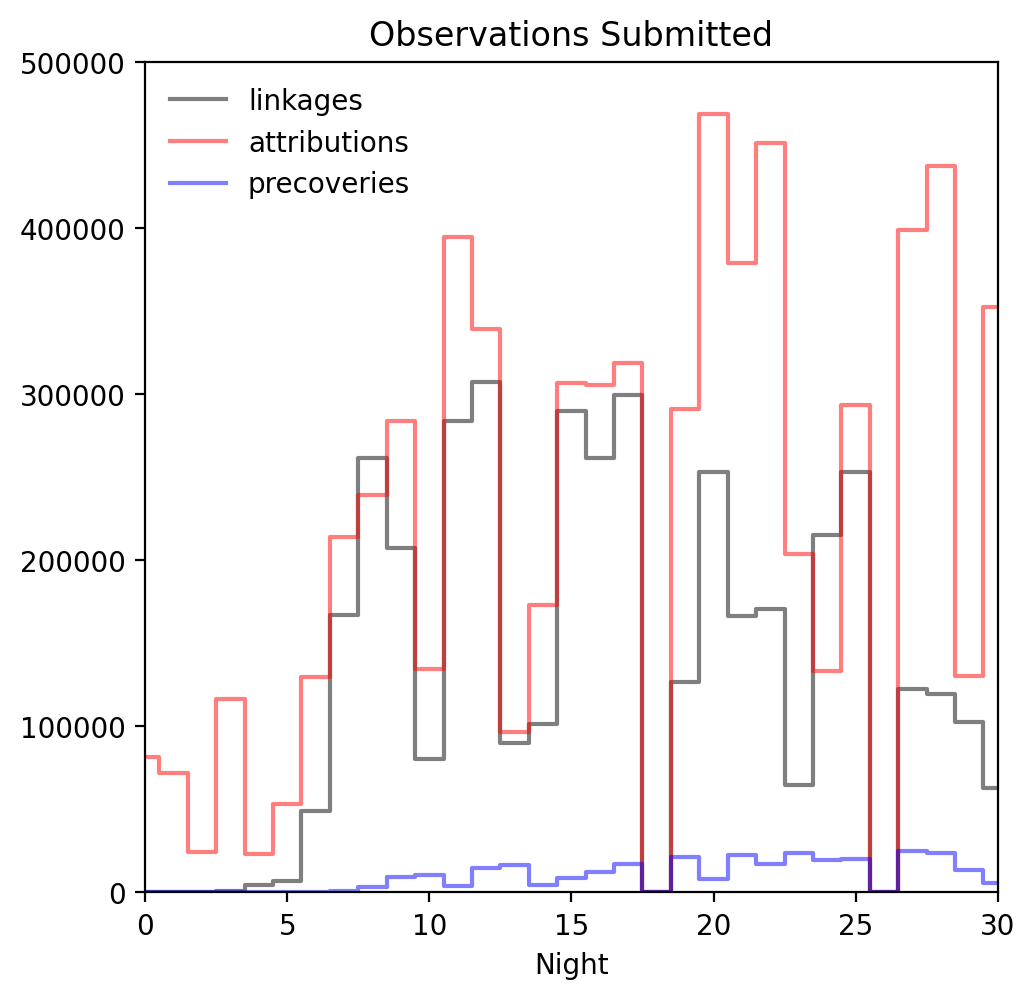

In [12]:
night_min = observations["night"].min()
night_max = observations["night"].max()
nights = np.arange(night_min, night_max + 1)

observations_linked = []
observations_attributed = []
observations_precovered = []

for night in nights:
    trksubs = all_linkages[all_linkages["submission_night"].isin([night])]["trkSub"].unique()
    observations_linked.append(
        linkage_members[linkage_members["trkSub"].isin(trksubs)]["obs_id"].nunique()
    )
    observations_attributed.append(
        observations_ap[
            (observations_ap["submission_night"].isin([night])
             & (observations_ap["attributed"] == 1))
        ]["obs_id"].nunique()
    )
    observations_precovered.append(
        observations_ap[
            (observations_ap["submission_night"].isin([night])
             & (observations_ap["precovered"] == 1))
        ]["obs_id"].nunique()
    )

fig, ax = plt.subplots(1, 1, dpi=200, figsize=(5.5, 5.5))
ax.step(
    nights - nights.min(), 
    observations_linked, 
    label="linkages", 
    c="k", 
    alpha=0.5, 
    where="mid"
)
ax.step(
    nights - nights.min(), 
    observations_attributed, 
    label="attributions", 
    c="r", 
    alpha=0.5, 
    where="mid"
)
ax.step(
    nights - nights.min(), 
    observations_precovered, 
    label="precoveries", 
    c="b", 
    alpha=0.5, 
    where="mid"
)
ax.set_ylim(0, 500000)
ax.set_xlim(0, 30)
ax.legend(frameon=False)
ax.set_title("Observations Submitted")
ax.set_xlabel("Night")
fig.savefig(
    "observations.png",
    bbox_inches="tight"
)

<ipython-input-13-4ffc6a281690>:26: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  a.set_xticks(np.arange(0, summary["submission_night"].nunique() + 1), 2)


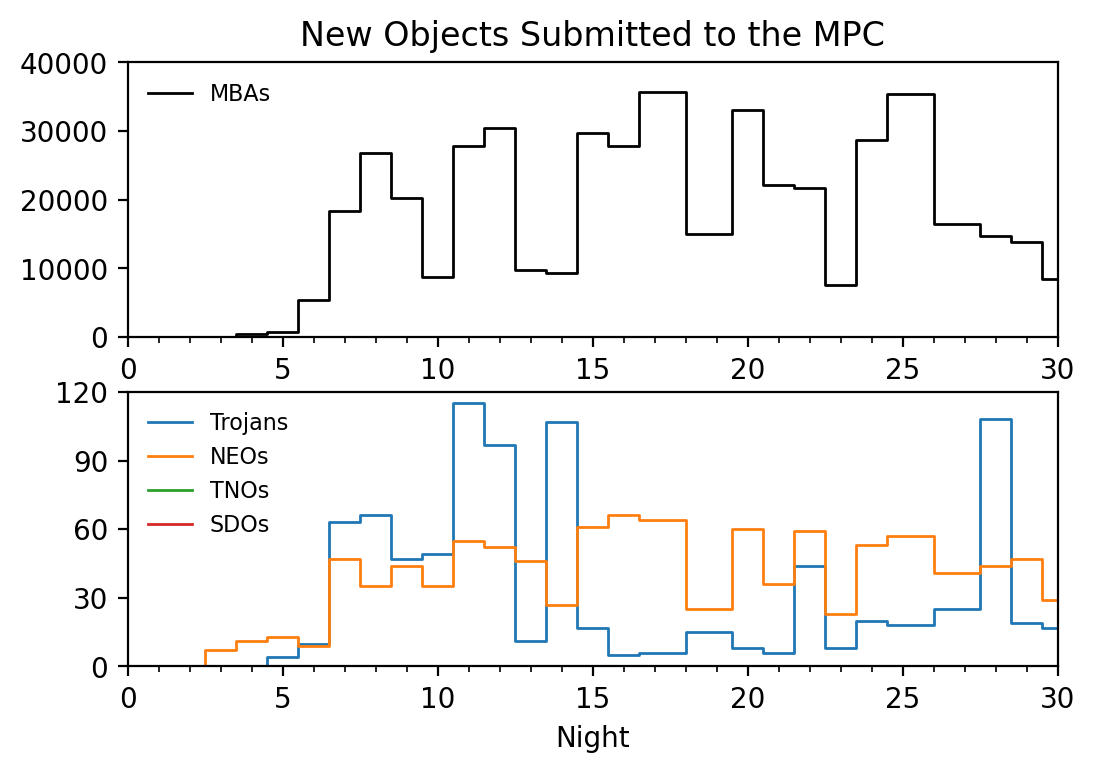

In [13]:
fig, ax = plt.subplots(2, 1, dpi=200)
for c in summary["class"].unique():
    summary_mask = (summary["class"] == c)
    if c == "All" or c == "MPC":
        continue
    if c == "MBAs":
        ax[0].step(
            summary[summary_mask]["submission_night"].values - summary["submission_night"].min(),
            summary[summary_mask]["findable"].values, 
            label=c,
            where="mid",
            c="k",
            lw=1
        )
        
    else:
        ax[1].step(
            summary[summary_mask]["submission_night"].values - summary["submission_night"].min(),
            summary[summary_mask]["findable"].values, 
            label=c,
            where="mid",
            lw=1
        )

for a in ax:
    a.set_xticks(np.arange(0, summary["submission_night"].nunique() + 1), 2)
    a.set_xlim(0, 30)
    a.legend(
        frameon=False, 
        fontsize=8
    )
ax[0].set_ylim(0, 40000)
ax[1].set_ylim(0, 120)
ax[1].set_yticks(np.arange(0, 150, 30))

ax[0].set_title("New Objects Submitted to the MPC")
ax[1].set_xlabel("Night")
fig.savefig(
    "discovery_rates.png",
    bbox_inches="tight"
)